## Homework3 - Predict fuel efficiency of car models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNet
import functools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

#### Reading the first sheet from the xlsx data files

In [2]:
# Reading the first sheet from the xlsx data files
data15 = pd.read_excel('data/2015FE.xlsx', sheet_name = 0)
data16 = pd.read_excel('data/2016FE.xlsx', sheet_name = 0)
data17 = pd.read_excel('data/2017FE.xlsx', sheet_name = 0)
data18 = pd.read_excel('data/2018FE.xlsx', sheet_name = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/2015FE.xlsx'

#### Drop all the columns that are empty (read as NaN)

In [ ]:
# Drop all the columns that are empty (read as NaN)
data15 = data15.dropna(axis = 1,how = 'all')
data16 = data16.dropna(axis = 1,how = 'all')
data17 = data17.dropna(axis = 1,how = 'all')
data18 = data18.dropna(axis = 1,how = 'all')

In [3]:
print(data15.shape, data16.shape, data17.shape)
print(data15.columns.shape, data16.columns.shape, data17.columns.shape ,data18.columns.shape)

NameError: name 'data15' is not defined

#### Concatenate the data from all the years

In [5]:
# Concatenate the data from all the years
all_data = pd.concat([data15, data16, data17], axis = 0, ignore_index = True)
print(all_data.shape)

(3701, 129)


### Feature analysis

The following cells describe the feature analysis done by us. The following observations were made as a part of this feature analysis: 
- $\text{feature}_{x} = \text{Round(feature}_{y})$ for some x and y
- Correlation between a feature and target. Visualized with scatter plots
- Very weak correlation between a feature and target. Visuzalized with box plots

While dropping the missing columns, we look at the entire training data because this helps us in preparing the data when we train the model with data assuming i.i.d. samples. At the same time, it prevents selection of those features that are important to a specific data set.

In [6]:
# Drop the columns that are empty, this is a double check
all_data = all_data.dropna(axis = 1, how = 'all')
all_data.shape

(3701, 129)

#### Visuzalization of the columns that are very sparse

(1216, 121)
(1216, 121)


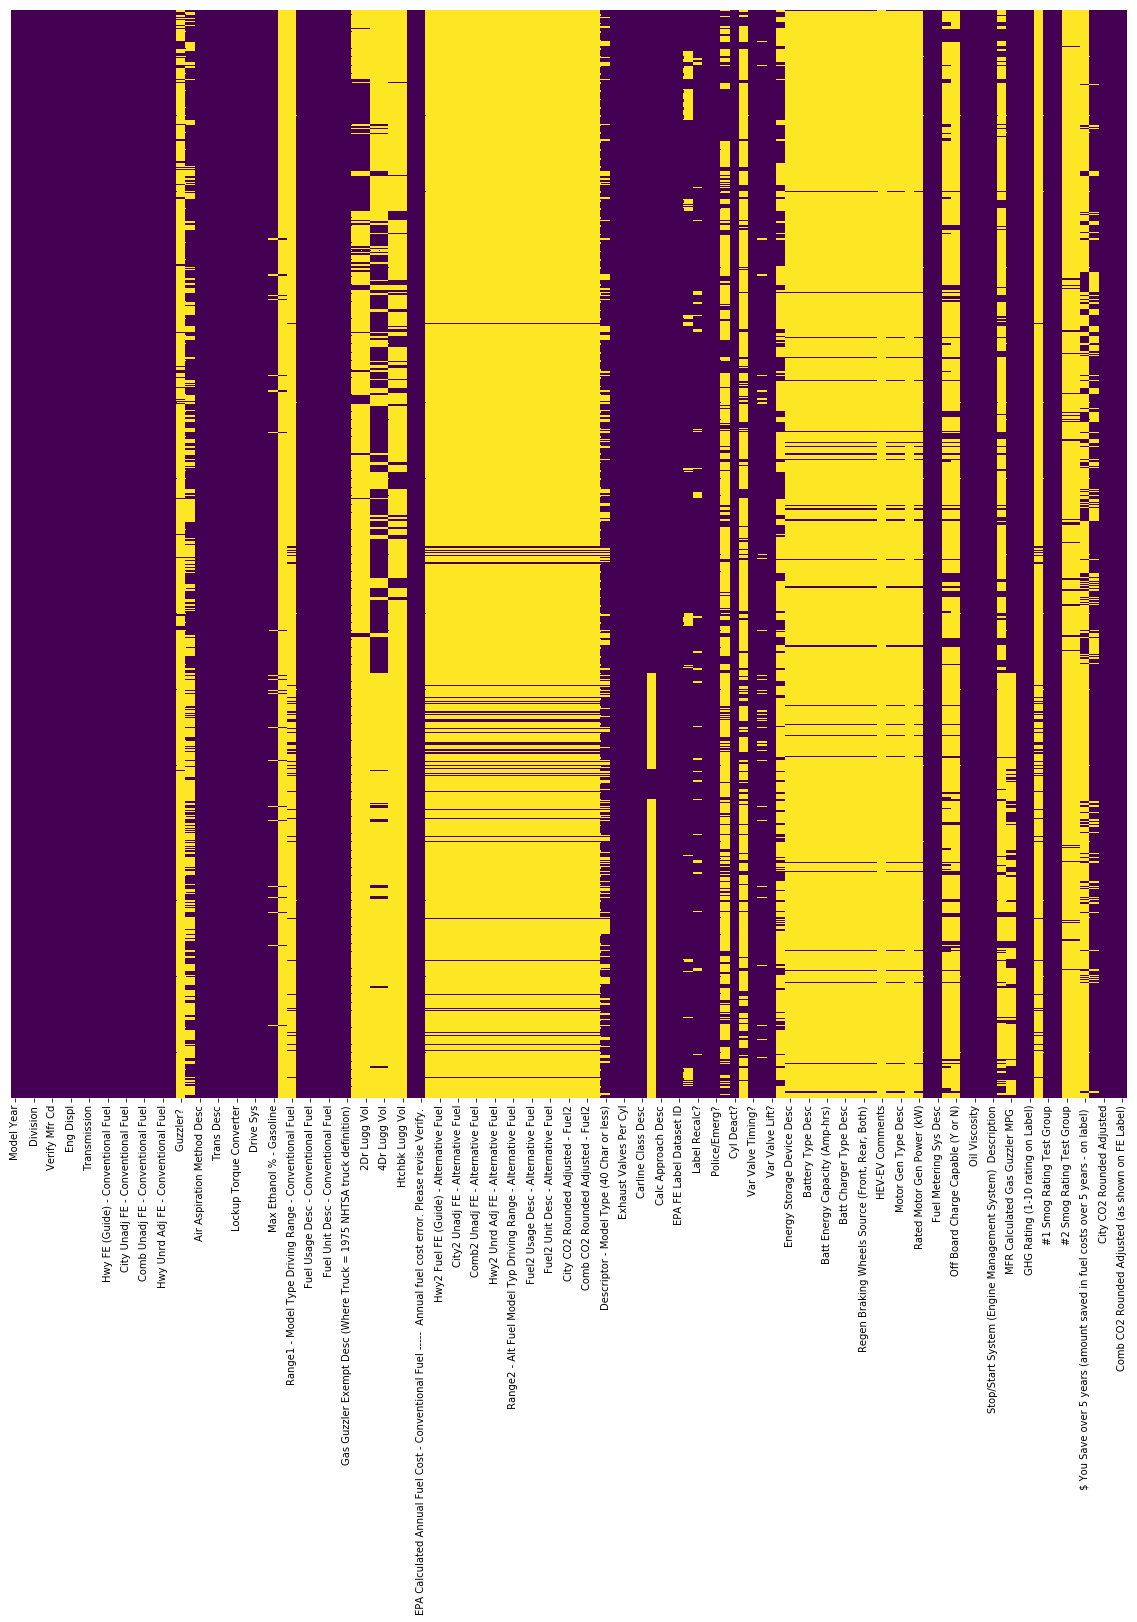

In [7]:
plt.figure(figsize=(20,20))
data18_pruned = data18.iloc[:, 0:155]
print(data18.shape)
print(data18_pruned.shape)
sns.heatmap(data18_pruned.isnull(),yticklabels=False,cmap='viridis',cbar=False)

#### Check for any rows that are completely empty and hence, invalid

In [8]:
# Check for any rows that are completely empty and hence, invalid
for row_index, row in all_data.iterrows():
    flag = False
    for column in row:
        if(column == '' or pd.isnull(column)):
            flag += 1
    if flag == len(all_data.columns):
        print(row)
    

#### This function is used to test a feature is a round off of another feature for all the rows. Hence, the integer column can be discarded.

In [9]:
# Check if col1_values = round(col2_values)
def isRound(col1_values, col2_values):
    all_mismatch = np.sum(col1_values != round(col2_values))
    return (all_mismatch == 0)

#### City FE (Guide) - Conventional Fuel = Round(City Unrd Adj FE - Conventional Fuel$

In [10]:
print(isRound(all_data['City FE (Guide) - Conventional Fuel'],all_data['City Unrd Adj FE - Conventional Fuel']))

True


#### Hwy FE (Guide) - Conventional Fuel = Round(Hwy Unrd Adj FE - Conventional Fuel)

In [11]:
print(isRound(all_data['Hwy FE (Guide) - Conventional Fuel'],all_data['Hwy Unrd Adj FE - Conventional Fuel']))

True


#### Comb FE (Guide) - Conventional Fuel = Round(Comb Unrd Adj FE - Conventional Fuel)

In [12]:
print(isRound(all_data['Comb FE (Guide) - Conventional Fuel'],all_data['Comb Unrd Adj FE - Conventional Fuel']))

True


#### In case of strong correlation between 2 features, one of them can be eliminated without significant information.

#### Strong linear relation between `City Unrd Adj FE - Conventional Fuel`and `Comb Unadj FE - Conventional Fuel`

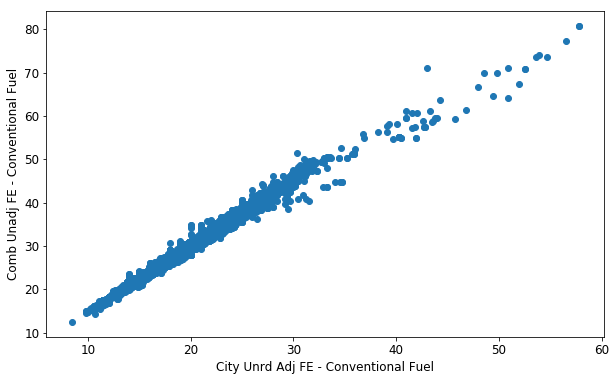

In [13]:
# This column has an invalid value `MOD` since all the other columns are float
indices_without_value_mod = ~(all_data['Comb Unadj FE - Conventional Fuel'] == 'Mod')

# Scatter between remaining rows
x1 = all_data[indices_without_value_mod]['City Unrd Adj FE - Conventional Fuel']
y1 = all_data[indices_without_value_mod]['Comb Unadj FE - Conventional Fuel']

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.scatter(x1,y1)
ax.set_xlabel('City Unrd Adj FE - Conventional Fuel', fontsize = 'large')
ax.set_ylabel('Comb Unadj FE - Conventional Fuel', fontsize = 'large')
ax.tick_params(labelsize='large')

#### Strong linear relation between `Hwy Unrd Adj FE - Conventional Fuel` and `Hwy Unadj FE - Conventional Fuel`

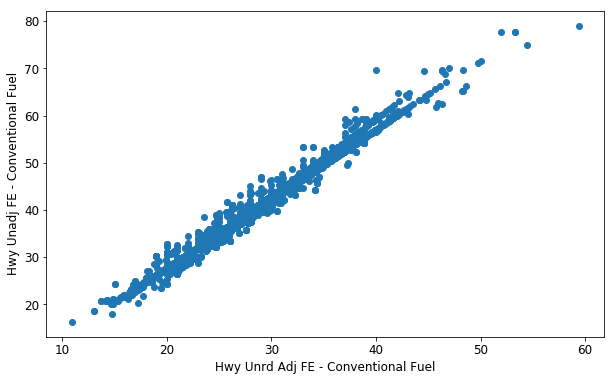

In [14]:
# This column has an invalid value `MOD` since all the other columns are float
indices_without_value_mod = ~(all_data['Hwy Unadj FE - Conventional Fuel'] == 'Mod')

# Scatter between remaining rows
x2 = all_data[indices_without_value_mod]['Hwy Unrd Adj FE - Conventional Fuel']
y2 = all_data[indices_without_value_mod]['Hwy Unadj FE - Conventional Fuel']

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.scatter(x2,y2)
ax.set_xlabel('Hwy Unrd Adj FE - Conventional Fuel', fontsize = 'large')
ax.set_ylabel('Hwy Unadj FE - Conventional Fuel', fontsize = 'large')
ax.tick_params(labelsize='large')

#### We hypothesized that `#Gears` should not affect fuel efficiency. 
The following plot shows that the `#Gears` feature does contain discriminative information. Thus, as of now, it is retained.

Text(0,0.5,'Comb Unrd Adj FE - Conventional Fuel')

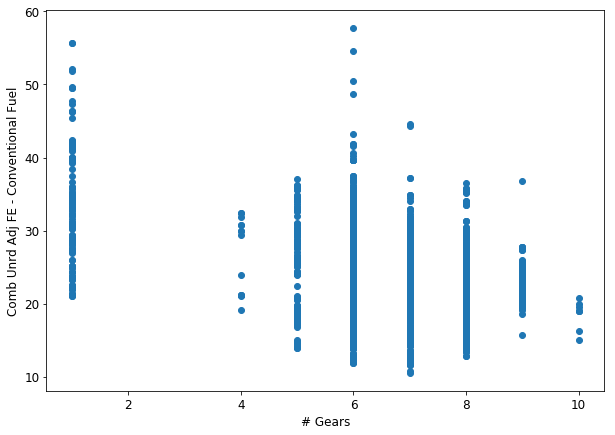

In [15]:
#scatter plot between # Gears and target variable
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.scatter(all_data['# Gears'],all_data['Comb Unrd Adj FE - Conventional Fuel'])
ax.tick_params(labelsize='large')
ax.set_xlabel('# Gears', fontsize='large')
ax.set_ylabel('Comb Unrd Adj FE - Conventional Fuel', fontsize='large')

#### Separating the data into month and year. 
The exact day of release is not an important feature. It is possible that the models released on a certain day are anamalous but this would be screened by the manufacturers themselves, so, this is a highly unlikely situation.

In [16]:
release_data_month = []
release_data_year = []
for row_index, row in enumerate(all_data['Release Date']):
    release_data_month.append(row.month)
    release_data_year.append(row.year)

all_data['Release month'] = release_data_month
all_data['Release year'] = release_data_year

#### The following hypothesis is used when visualizing boxplots
- If the boxplots for 2 given values of a categorical column overlap signitficantly, it means that these 2 values don't contain any discriminative information about the target variable.
- If all the boxplots for all the values of a categorical column overlap significantly, the categorical column doesn't contain/contains very less discrimiative information about the target variable.
- The outliers can be ignored when comparing 2 boxplots because the regression model learnt needs to be robust to outliers.

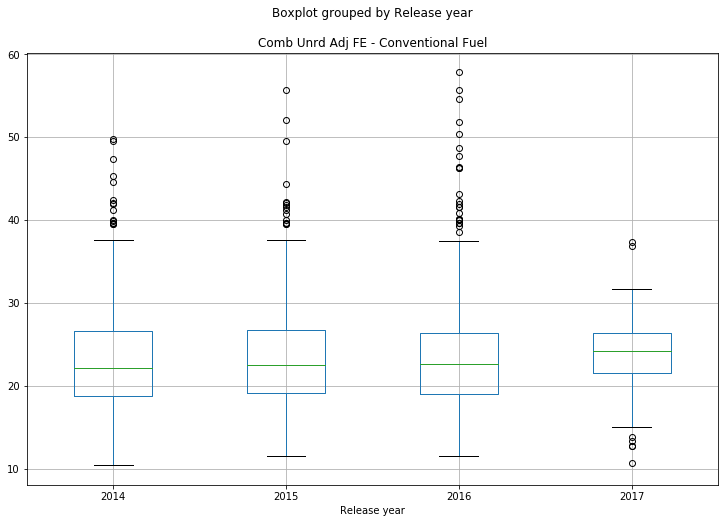

In [17]:
ax = all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Release year', figsize=(12,8))

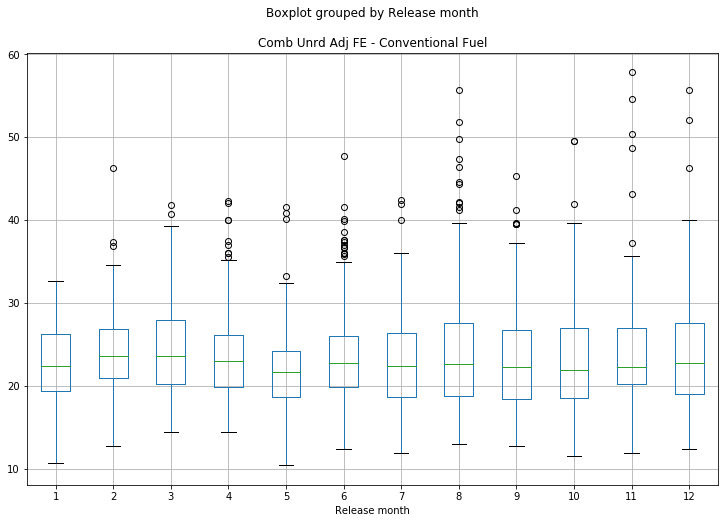

In [18]:
all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Release month', figsize=(12,8))

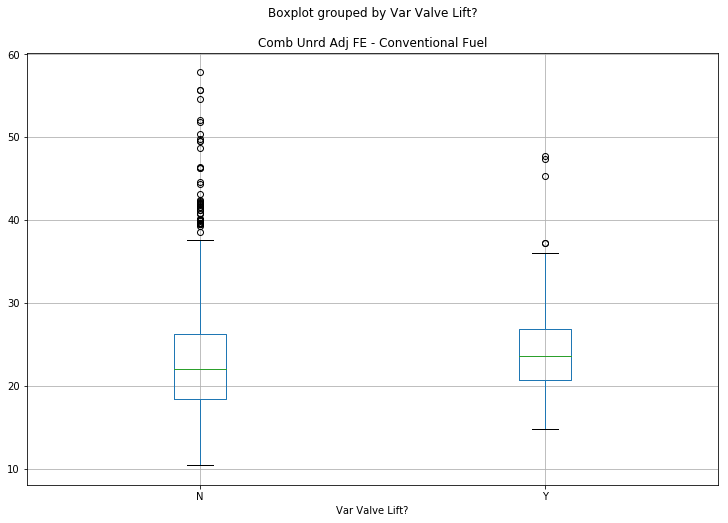

In [19]:
all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Var Valve Lift?', figsize=(12,8))

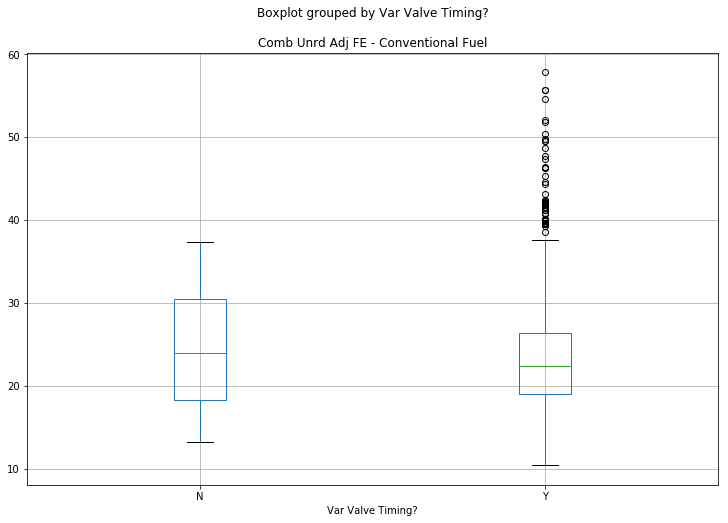

In [20]:
all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Var Valve Timing?', figsize=(12,8))

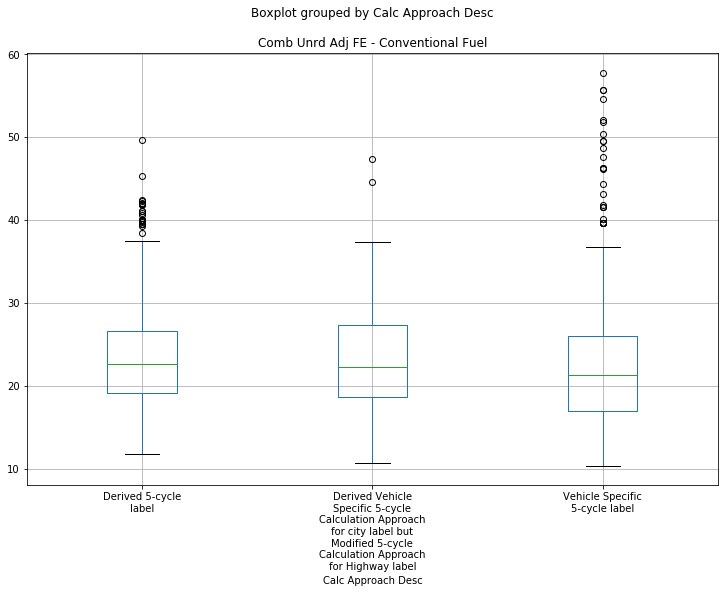

In [21]:
from textwrap import wrap
ax = all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Calc Approach Desc', figsize=(12,8))
xtick_labels = list(ax.get_xticklabels())
xtick_labels = [l.get_text() for l in xtick_labels]
xtick_labels = [ '\n'.join(wrap(l, 20)) for l in xtick_labels ]
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis = 'x')

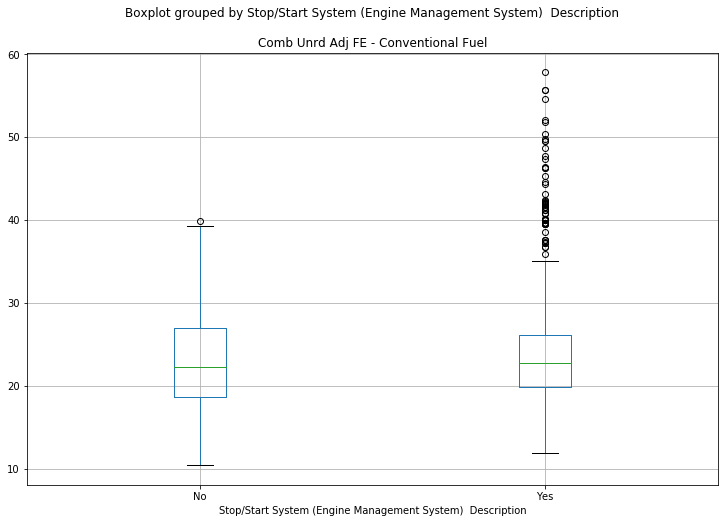

In [22]:
all_data.boxplot('Comb Unrd Adj FE - Conventional Fuel', by = 'Stop/Start System (Engine Management System)  Description', figsize=(12,8))

#### One-to-one mapping is checked by following criteria
DISTINCT($feature_{x}$) = DISTINCT($feature_{y}$) = DISTINCT(zip($feature_{x}$, $feature_{y}$))

The above criteria verfiies if the map between $feature_{x}$` and $feature_{y}$ is a bijection and hence, one-to-one.
#### If there is one-to-one mapping between 2 features, one of them can be eliminated.

#### `Mfr Name` $\stackrel{1-1}{\longleftrightarrow}$ `Verify Mfr Cd`

In [23]:
# One-to-One mapping between the two columns
assert(
    len(set(all_data['Mfr Name'])) == 
    len(set(zip(all_data['Mfr Name'], all_data['Verify Mfr Cd'])))
)
assert(
    len(set(all_data['Verify Mfr Cd'])) == 
    len(set(zip(all_data['Mfr Name'], all_data['Verify Mfr Cd'])))
)
one_one_Mfr_Name = set(zip(all_data['Mfr Name'], all_data['Verify Mfr Cd']))

#### `Fuel Usage  - Conventional Fuel` $\stackrel{1-1}{\longleftrightarrow}$ `Fuel Usage Desc - Conventional Fuel`

In [24]:
# One-to-One mapping between the two columns
assert(
    len(set(all_data['Fuel Usage  - Conventional Fuel'])) ==
    len(set(zip(all_data['Fuel Usage  - Conventional Fuel'], all_data['Fuel Usage Desc - Conventional Fuel'])))
)
assert(
    len(set(all_data['Fuel Usage Desc - Conventional Fuel'])) ==
    len(set(zip(all_data['Fuel Usage  - Conventional Fuel'], all_data['Fuel Usage Desc - Conventional Fuel'])))
)
one_one_Fuel_Usage_Desc = set(zip(all_data['Fuel Usage  - Conventional Fuel'], all_data['Fuel Usage Desc - Conventional Fuel']))

#### `Fuel Unit - Conventional Fuel` $\stackrel{1-1}{\longleftrightarrow}$ `Fuel Unit Desc - Conventional Fuel`

In [25]:
# One-to-One mapping between the two columns
assert(
    len(set(all_data['Fuel Unit - Conventional Fuel'])) ==
    len(set(zip(all_data['Fuel Unit - Conventional Fuel'], all_data['Fuel Unit Desc - Conventional Fuel'])))
)
assert(
    len(set(all_data['Fuel Unit Desc - Conventional Fuel'])) ==
    len(set(zip(all_data['Fuel Unit - Conventional Fuel'], all_data['Fuel Unit Desc - Conventional Fuel'])))
)
one_one_Fuel_Unit_Desc = set(zip(all_data['Fuel Unit - Conventional Fuel'], all_data['Fuel Unit Desc - Conventional Fuel']))

#### `Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition` $\stackrel{1-1}{\longleftrightarrow}$ `Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)`

In [26]:
# One-to-One mapping between the two columns
assert(
    len(set(all_data['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'])) ==
    len(set(zip(all_data['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'], all_data['Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)'])))
)
assert(
    len(set(all_data['Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)'])) ==
    len(set(zip(all_data['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'], all_data['Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)'])))
)
one_one_Guzzler_Exempt_Desc = set(zip(all_data['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'], all_data['Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)']))

#### `Annual Fuel1 Cost - Conventional Fuel` $\stackrel{1-1}{\longleftrightarrow}$ `EPA Calculated Annual Fuel Cost - Conventional Fuel -----  Annual fuel cost error. Please revise Verify. `

In [27]:
# One-to-One mapping between the two columns
np.sum(all_data['Annual Fuel1 Cost - Conventional Fuel'] != 
        all_data['EPA Calculated Annual Fuel Cost - Conventional Fuel -----  Annual fuel cost error. Please revise Verify. '])

0

#### The 19 points at which the columns don't agree are taken to be outliers. The column `Intake valves per Cyl` is dropped.

#### `Intake Valves Per Cyl` $\stackrel{1-1}{\longleftrightarrow}$ `Exhaust Valves Per Cyl`

In [28]:
# One-to-One mapping between the two columns
# 19 outliers
all_data[all_data['Intake Valves Per Cyl'] != all_data['Exhaust Valves Per Cyl']]['Verify Mfr Cd']

58      MBX
385     MBX
740     MBX
741     MBX
1305    MBX
1317    PGN
1602    MBX
1958    MBX
1959    MBX
1962    MBX
2422    MBX
2508    MBX
2690    MBX
2692    MBX
2839    MBX
3159    MBX
3160    MBX
3164    MBX
3661    MBX
Name: Verify Mfr Cd, dtype: object

#### `Carline Class` $\stackrel{1-1}{\longleftrightarrow}$ `Carline Class Desc`

In [29]:
# One-to-One mapping between the two columns
assert(
    len(set(all_data['Carline Class'])) == 
    len(set(zip(all_data['Carline Class'], all_data['Carline Class Desc'])))
)
assert(
    len(set(all_data['Carline Class Desc'])) ==
    len(set(zip(all_data['Carline Class'], all_data['Carline Class Desc'])))
)
one_one_Carlineclass_desc = set(zip(all_data['Carline Class'], all_data['Carline Class Desc']))

#### `Air Aspir Method` $\stackrel{1-1}{\longleftrightarrow}$ `Air Aspiration Method Desc`

In [30]:
# One-to-One mapping between the two columns
set(zip(all_data['Air Aspir Method'], all_data['Air Aspiration Method Desc']))
assert(
    len(set(all_data['Air Aspir Method'])) ==
    len(set(zip(all_data['Air Aspir Method'], all_data['Air Aspiration Method Desc'])))
)
assert(
    len(set(all_data['Air Aspiration Method Desc'])) ==
    len(set(zip(all_data['Air Aspir Method'], all_data['Air Aspiration Method Desc'])))
)
one_one_AirAspiration_desc = set(zip(all_data['Air Aspir Method'], all_data['Air Aspiration Method Desc']))

#### `Trans` $\stackrel{1-1}{\longleftrightarrow}$ `Trans Desc`

In [31]:
# One-to-One mapping between the two columns
assert(
    len((set(all_data['Trans']))) == 
    len(set(zip(all_data['Trans'], all_data['Trans Desc'])))
)
assert(
    len(set(all_data['Trans Desc'])) == 
    len(set(zip(all_data['Trans'], all_data['Trans Desc'])))
)
one_one_Trans_desc = set(zip(all_data['Trans'], all_data['Trans Desc']))

#### Except for the missing values and the value `Mod`, there is one-to-one mapping between `Relabel` and `Relabel - label value increased`. The latter is dropped

#### `Relabel` $\stackrel{1-1}{\longleftrightarrow}$ `Relabel Desc`

In [32]:
# One-to-One mapping between the two columns
set(zip(all_data['Relabel'], all_data['Relabel Desc']))

{('RH', 'Relabel - label value increased'),
 ('RL', 'Relabel - label value decreased'),
 (nan, 'Mod'),
 (nan, nan)}

#### `Fuel Metering Sys Cd` $\stackrel{1-1}{\longleftrightarrow}$ `Fuel Metering Sys Desc`

In [33]:
# One-to-One mapping between the two columns
assert(
    len((set(all_data['Fuel Metering Sys Cd']))) == 
    len(set(zip(all_data['Fuel Metering Sys Cd'], all_data['Fuel Metering Sys Desc'])))
)
assert(
    len(set(all_data['Fuel Metering Sys Desc'])) == 
    len(set(zip(all_data['Fuel Metering Sys Cd'], all_data['Fuel Metering Sys Desc'])))
)#1
one_one_Fuelmetsys_desc = set(zip(all_data['Fuel Metering Sys Cd'], all_data['Fuel Metering Sys Desc']))

The 44 points at which the columns don't agree are taken to be outliers.

In [34]:
# One-to-One mapping between the two columns
# 44 outliers
np.sum(all_data['FE Rating (1-10 rating on Label)'] != all_data['GHG Rating (1-10 rating on Label)'])

44

#### Columns that have the same value for (nearly) all the rows

In [35]:
# All the rows have the same value
len(all_data['Suppressed?'] == 'N') #3701

3701

In [36]:
# All the rows have the same value
len(all_data['Police/Emerg?'] == 'N') #3701

3701

In [37]:
# All the rows have the same value
np.sum(pd.isnull(all_data['# Capacitors'])) #3700

3700

##### Columns with less than 1% data, useless columns

In [38]:
for col in all_data.columns:
    if sum(~(pd.isnull(all_data[col].values))) < 80:
        print(col)

# Capacitors
#3 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 3)
#3 Smog Rating Test Group
Comments
HEV-EV Comments
Max Biodiesel %
Motor Gen Type, If Other
Regen Braking Type, If Other
Relabel
Relabel Desc
Trans, Other


### Set of columns to be deleted

In [39]:
columns_to_be_deleted = set()

### Delete all the columns that leak information about FE directly
These columns are deleted after checking their correlation coefficients. Further, according to instructions given, these columns have to dropped anyways.

In [40]:
col_containing_FE = []
for col in all_data.columns:
    if('FE' in col):
        col_containing_FE.append(col)

columns_to_be_deleted = columns_to_be_deleted | set(col_containing_FE)
col_containing_FE

['City FE (Guide) - Conventional Fuel',
 'City Unadj FE - Conventional Fuel',
 'City Unrd Adj FE - Conventional Fuel',
 'City2 FE (Guide) - Alternative Fuel',
 'City2 Unadj FE - Alternative Fuel',
 'City2 Unrd Adj FE - Alternative Fuel',
 'Cmb2 Unrd Adj FE - Alternative Fuel',
 'Comb CO2 Rounded Adjusted (as shown on FE Label)',
 'Comb FE (Guide) - Conventional Fuel',
 'Comb Unadj FE - Conventional Fuel',
 'Comb Unrd Adj FE - Conventional Fuel',
 'Comb2 Fuel FE (Guide) - Alternative Fuel',
 'Comb2 Unadj FE - Alternative Fuel',
 'EPA FE Label Dataset ID',
 'FE Rating (1-10 rating on Label)',
 'Hwy FE (Guide) - Conventional Fuel',
 'Hwy Unadj FE - Conventional Fuel',
 'Hwy Unrd Adj FE - Conventional Fuel',
 'Hwy2 Fuel FE (Guide) - Alternative Fuel',
 'Hwy2 Unadj FE - Alternative Fuel',
 'Hwy2 Unrd Adj FE - Alternative Fuel']

### Delete textual data columns
The textual data columns contain comments which don't offer any discriminative information. Additionally, these columns are too sparse to be any use or to be be imputed.

In [41]:
columns_to_be_deleted.add('Comments - Mfr Eng Cnfg')
columns_to_be_deleted.add('Cyl Deact Desc')
columns_to_be_deleted.add('Var Valve Timing Desc')
columns_to_be_deleted.add('Var Valve Lift Desc')
columns_to_be_deleted.add('HEV-EV Comments')

### Deleting columns that map one-to-one with other columns
While choosing the column to be retained, the one which contains more information is retained. The column is dropped if it is either textual (contains the word `DESC` implying description). The other criteria for dropping a column is that it is difficult to process than its one-to-one counterpart.

In [42]:
columns_to_be_deleted.add('Mfr Name')
columns_to_be_deleted.add('Fuel Usage Desc - Conventional Fuel')
columns_to_be_deleted.add('Fuel Unit Desc - Conventional Fuel')
columns_to_be_deleted.add('Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)')
columns_to_be_deleted.add('Carline Class Desc')
columns_to_be_deleted.add('Air Aspiration Method Desc')
columns_to_be_deleted.add('Trans Desc')
columns_to_be_deleted.add('Fuel Metering Sys Desc')

### Deleting columns related to Guzzlers because they imply low FE

In [43]:
columns_to_be_deleted.add('Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)')
columns_to_be_deleted.add('Guzzler? ')

### Deleting the columns that have the same value for (nearly) all the rows

In [44]:
columns_to_be_deleted.add('Suppressed?')
columns_to_be_deleted.add('Police/Emerg?')
columns_to_be_deleted.add('# Capacitors')

### Deleting columns with less than 1% data
These columns don't provide any discriminatory information nor can they be imputed.

In [45]:
for col in all_data.columns:
    if sum(~(pd.isnull(all_data[col].values))) < 30:
        columns_to_be_deleted.add(col)

### Deleting EPA calculated features
These features are not provided by the manufacturer and hence, dropped.

In [46]:
columns_to_be_deleted.add('EPA Calculated Annual Fuel Cost - Conventional Fuel -----  Annual fuel cost error. Please revise Verify. ')
columns_to_be_deleted.add('EPA FE Label Dataset ID')
columns_to_be_deleted.add('Fuel2 EPA Calculated Annual Fuel Cost - Alternative Fuel')
columns_to_be_deleted.add('GHG 1-10 rating on Ethanol (EPA Determined)')

### Deleting irrelevant columns

In [47]:
irrelevant_columns = [
    'Car/Truck Category - Cash for Clunkers Bill.',
    'Descriptor - Model Type (40 Char or less)',
    'Driver Cntrl Regen Braking?',
    'Energy Storage Device Desc',
    'Fuel Unit - Conventional Fuel',
    'Fuel2 Unit - Alternative Fuel',
    'Fuel2 Unit Desc - Alternative Fuel',
    'Regen Braking Wheels Source (Front, Rear, Both)',
    'Stop/Start System (Engine Management System)  Description',
    'Trans Creeper Gear',
    'Battery Type Desc',
    'Batt Charger Type Desc',
    'Rated Motor Gen Power (kW)',
    'Motor Gen Type, If Other',
    ' Fuel2 Usage - Alternative Fuel',
    ' Fuel2 Usage Desc - Alternative Fuel',
    'Regen Braking Type Desc',
    'Unique Label?',
    'Off Board Charge Capable (Y or N)',
    'Range1 - Model Type Driving Range - Conventional Fuel',
    ' Range2 - Alt Fuel Model Typ Driving Range - Alternative Fuel',
    'Total Voltage for Battery Pack(s)',
    'Hwy CO2 Rounded Adjusted',
    '# Batteries',
    '# Drive Motor Gen',
    'Batt Energy Capacity (Amp-hrs)',
    'Batt Specific Energy (Watt-hr/kg)',
    'City CO2 Rounded Adjusted - Fuel2',
    'Comb CO2 Rounded Adjusted - Fuel2',
    'Fuel2 Annual Fuel Cost - Alternative Fuel',
    'Carline',
    '#1 Smog Rating Test Group',
    'Stop/Start System (Engine Management System) Code',
    'Calc Approach Desc',
    'Model Year',
    'Division',
    'Verify Mfr Cd'
]

columns_to_be_deleted = columns_to_be_deleted | set(irrelevant_columns)

### Deleting categorical columns that have mixed values
These columns were dropped because they added a lot of preprocessing overhead. A few baseline models were trained without them which gave >90% accuracy each. Further, the best model that we trained has greater than 95% accuracy. Thus, these columns are dropped in the favor of incurring additional preprocessing for the existing columns

In [48]:
categorical_with_nonan = []
mixed_categorical_columns = []
for col in all_data.columns:
    if(all_data[col].dtype == np.dtype('O')):
        
        all_values_this_col = list(set(all_data[col]))
        flag = True
        for value in all_values_this_col:
            if(type(value) != type('a')):
                flag = False
                break
        if(flag == True and np.sum(pd.isnull(all_data[col])) == 0):
            categorical_with_nonan.append(col)
        else: 
            mixed_categorical_columns.append(col)
    
columns_to_be_deleted = columns_to_be_deleted | set(mixed_categorical_columns)

### Deleting these columns because they don't segregrate target well enough, refer to the box plots above

In [49]:
columns_to_be_deleted.add('Release Date')
columns_to_be_deleted.add('Release year')
columns_to_be_deleted.add('Release month')
columns_to_be_deleted.add('Var Valve Lift?')
columns_to_be_deleted.add('Var Valve Timing?')

### Retaining relevant columns

In [50]:
columns_to_be_retained = set()

### Retaining columns that can imputed
These columns have dense enough to be imputed, hence, retained.

In [51]:
columns_to_be_imputed = [
    '#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)',
    'GHG Rating (1-10 rating on Label)',
    'MFR Calculated Gas Guzzler MPG ',
]

columns_to_be_retained = columns_to_be_retained | set(columns_to_be_imputed)

### Retaining the target column

In [52]:
target_column = 'Comb Unrd Adj FE - Conventional Fuel'
columns_to_be_retained.add(target_column)

In [53]:
for col in columns_to_be_retained:
    columns_to_be_deleted.remove(col)

In [54]:
print('# Columns to be deleted: %d' % (len(columns_to_be_deleted)))

# Columns to be deleted: 97


In [55]:
for col in columns_to_be_deleted:
    del all_data[col]

#### This is the baseline file which contains all the features that we considered relevant

In [56]:
all_data.to_excel('newdata/data_v1.xlsx', index = False)

### Preprocessing starts here

Following are a few `Transformers` that we used to preprocess the retained features. Each transformation is written as a separate transformer. The `Transformer` coding style is used because it is modular and aligns well with the `sklearn's` coding style. 

Some of the columns have the `Mod` value in the rows. This value is processed as string by pandas
and it doesn't offer any discriminative information. For numerical columns, `ModReplacer`  replaces `Mod` by
`np.nan` and the column is forced to assume numerical data type so that it can be imputed

In [9]:
class ModReplacer(BaseEstimator, TransformerMixin):
    def __init__(self):
        
        #columns that contain the mod values
        self.columns_with_mod_values = [
            '#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)',
            'GHG Rating (1-10 rating on Label)',
            'MFR Calculated Gas Guzzler MPG '
        ]
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X_dup = X.copy()
        for col in self.columns_with_mod_values:
            if(X[col].dtype == np.dtype('O')):
                indices_with_value_mod = (X_dup[col] == 'Mod')
                X_dup[col][indices_with_value_mod] = np.nan
                X_dup[col] = X_dup[col].apply(pd.to_numeric)
        
        return X_dup
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

The column `Transmission` has many different values. But, all the values are derived from 2 base values: `Automatic` and `Manual`. We hypothesized that all of the values might not contain discriminative information. Thus, we coerced the unecessarily specific values to one of `Automatic` or `Manual`.

`TransmissionTransformer` helped reduce the number of one-hot features. Further, our hypothesis was verified by the high accuracy of the models we trained.

In [10]:
class TransmissionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_dup = X.copy()
        X_dup['Transmission'] = X_dup['Transmission'].apply(lambda x: x.split('(')[0])
        return X_dup
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

`NumericalColumnExtractor` is a very simple transformtion that extracts the numerical columns of the given data set. This is used because the transformers (example - `PolynomialFeatures()`) follwing it orocesses numerical features only. 

In [11]:
class NumericalColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):    
        self.categorical_columns = [col for col in X.columns if X[col].dtype == np.dtype('O')]
        
    def transform(self, X, y = None):
        X_data_numerical = X[list(set(X.columns) - set(self.categorical_columns))]
        return X_data_numerical
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

`NumericalColumnImputer` transformor expects the data to have been processed by `ModReplacer` apriori. It extracts the numerical columns out of the given data set, computes the `Imputer` on them and uses it to transform any given data set.
The necessity of running `ModReplacer` apriori is because `ModReplacer` replaces the invalid `Mod` values with `np.nan` and thus, sklearn's `Imputer()` transformation can be used directly on these columns

In [12]:
#Extracts the numerical columns, imputes them using Imputer
class NumericalColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        self.numerical_columns = [col for col in X.columns if X[col].dtype != np.dtype('O')]
        X_numerical = X[self.numerical_columns]
        self.numerical_imputer = Imputer(strategy = "mean")
        self.numerical_imputer.fit(X_numerical, y)
        return self
    
    def transform(self, X, y = None):
        
        
        
        X_numerical = X[self.numerical_columns].copy(deep = True)
        X_numerical_imputed = self.numerical_imputer.transform(X_numerical)
        X_numerical_imputed = pd.DataFrame(X_numerical_imputed, columns = self.numerical_columns)
        
        for col in X_numerical_imputed.columns:
            if(X_numerical_imputed[col].dtype == np.dtype('O')):
                if(np.sum(pd.isnull(X_numerical_imputed[col])) > 0):
                    print(col)
        
        X_dup = X.copy(deep = True)

        #remove the old numerical columns
        for numerical_column in self.numerical_columns:
            del X_dup[numerical_column]
        
        
        X_dup = X_dup.reset_index()
        X_numerical_imputed = X_numerical_imputed.reset_index()
        X_dup = pd.concat([X_dup, X_numerical_imputed], axis = 1, ignore_index = True)
        
        
        return X_dup
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)
    


`CategoricalTransformer` extracts categorical columns and transforms them using the `OneHotTransformer`

In [13]:
#extracts the categorical columns and one-hot encodes them using the OneHotTransformer
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        self.categorical_columns = [col for col in X.columns if X[col].dtype == np.dtype('O')]
        
        
        X_categorical = X[self.categorical_columns].copy(deep = True)
        self.one_hot_transformer = OneHotTransformer()
        self.one_hot_transformer.fit(X_categorical, y)
        return self
    
    def transform(self, X, y = None):
        X_categorical = X[self.categorical_columns]
        X_categorical_one_hot = self.one_hot_transformer.transform(X_categorical, y)
        
        X_dup = X.copy(deep = True)
        
        #drop the old categorical columns
        for categorical_column in self.categorical_columns:
            del X_dup[categorical_column]
        
        X_dup = pd.concat([X_dup, X_categorical_one_hot], axis = 1)
        
        return X_dup
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)
        
    


`OneHotTransformer` transformer uses `pd.get_dummies` to transform categorical columns to the corresponding `one-hot` columns

In [14]:
# One hot encodes the categorical columns, expects a data frame with categorical columns only, 
# returns a data frame
class OneHotTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
            
    def fit(self, X, y = None):
        self.values_for_categorical_columns = dict()
        for col in X.columns:
            self.values_for_categorical_columns[col] = set(X[col])
        return self
    def transform(self, X, y = None):
        for col in X.columns:
            X[col] = pd.Categorical(X[col], categories = set(self.values_for_categorical_columns[col]))
        
        return pd.get_dummies(X)
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

`MyTransformer` segregates the numerical and categorical features. Runs the `NumericalPolyTransformer()` on numerical features
and `OneHotTransformert()` on the categorical features

In [15]:
# Segregates the numerical and categorical features. Runs the NumericalPolyTransformer() on numerical features
# and OneHotTransformert() on the categorical features

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, poly_features):
        assert(poly_features is not None)
        
        self.poly_features = poly_features
        self.numerical_columns = []
        self.categorical_columns = []
        
    def SeparteCategoricalAndNumericalColumns(self, X):
        for col in X:
            if(X[col].dtype != np.dtype('O')):
                self.numerical_columns.append(col)
            else:
                self.categorical_columns.append(col)
    def fit(self, X, y = None):
        
        self.SeparteCategoricalAndNumericalColumns(X)
        
        self.X_numerical = X[self.numerical_columns]
        self.X_categorical = X[self.categorical_columns]
        
        self.numerical_poly_transformer = NumericalPolyTransformer(self.poly_features)
        self.numerical_poly_transformer.fit(self.X_numerical, y)
        self.one_hot_transformer = OneHotTransformer()
        self.one_hot_transformer.fit(self.X_categorical, y)
        
    def transform(self, X, y = None):
        self.X_numerical = X[self.numerical_columns]
        self.X_categorical = X[self.categorical_columns]
        
        X_numerical_transformed = self.numerical_poly_transformer.transform(self.X_numerical, y)
        X_categorical_transformed = self.one_hot_transformer.transform(self.X_categorical
                                                                       , y)
        
        return np.concatenate([X_numerical_transformed, X_categorical_transformed], axis = 1)
        
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)
        


# Input: DataFrame/Numpy matrix with numerical columns
# Assumes that the numerical features have been imputed already

class NumericalPolyTransformer(BaseEstimator, TransformerMixin):

    # data - Pandas data frame
    def __init__(self, poly_features = None):
        assert(poly_features is not None)
        self.poly_features = poly_features

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_dup = X.copy(deep = True)
        X_dup_poly = self.poly_features.fit_transform(X_dup)
        return X_dup_poly

    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

# One hot encodes the categorical columns
class OneHotTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
            
    def fit(self, X, y = None):
        self.values_for_categorical_columns = dict()
        for col in X.columns:
            self.values_for_categorical_columns[col] = set(X[col])
    
    def transform(self, X, y = None):
        for col in X.columns:
            X[col] = pd.Categorical(X[col], categories = set(self.values_for_categorical_columns[col]))
        
        return pd.get_dummies(X)
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        X = self.transform(X, y)
        return X

In addition to removing the columns that were known to leak information about target explicitly, we used this transformer because of unusually high test accuracies with some of our models. `CorrColumnRemover` removes the columns that are highly or weakly correlated. We used `0.8` and `0.1` as empirical values for high correlation and weak correlation respectively.

In [16]:
# X should contain the target column
class CorrColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound_on_corr = 0.1, higher_bound_on_corr = 0.9, print_deleted_columns = False):
        
        #contains the columns that are either highly correlated or very weakly correlated
        self.corr_columns = []
        self.higher_bound_on_corr = higher_bound_on_corr
        self.lower_bound_on_corr = lower_bound_on_corr
        self.print_deleted_columns = print_deleted_columns
    
    def fit(self, X, y = None):
        
        #extract the numerical columns
        numerical_columns = []
        for col in X.columns:
            if(X[col].dtype != np.dtype('O')):
                numerical_columns.append(col)
        
        X_numerical = X[numerical_columns]
        corr_matrix = X_numerical.corr()
        corr_coefficients = corr_matrix['Comb Unrd Adj FE - Conventional Fuel']
        high_corr_columns = X_numerical.columns[abs(corr_coefficients) > self.higher_bound_on_corr]
        low_corr_columns = X_numerical.columns[abs(corr_coefficients) < self.lower_bound_on_corr]
        
        self.corr_columns = list(set(high_corr_columns) | set(low_corr_columns))
        
        self.corr_columns.remove('Comb Unrd Adj FE - Conventional Fuel')
        
        if(self.print_deleted_columns):
            print(self.corr_columns)
            
    def transform(self, X, y = None):
        X_dup = X.copy()
        for col in self.corr_columns:
            del X_dup[col]
        return X_dup
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)
        

#### This transformer is used to ensure that the set of features used across folds of validation data is consistent.

In [17]:
class FeaturePrinter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        print(X.shape)
        return X
    
    def fit_transform(self, X, y = None):
        print(X.shape)
        return X

### Baseline Model: Linear Regression on numerical regression

In [110]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [111]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [112]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8, print_deleted_columns=True)

In [113]:
all_data = corr_column_remover.fit_transform(all_data)

['Htchbk Lugg Vol', '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) ', '2Dr Lugg Vol', 'Annual Fuel1 Cost - Conventional Fuel', 'Htchbk Pass Vol', '$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) ', 'Hwy CO2 Rounded Adjusted - Fuel2', '4Dr Lugg Vol', '2Dr Pass Vol', 'City CO2 Rounded Adjusted']


#### Extracting necessary columns only

In [114]:
data_2018 = data_2018[all_data.columns]

In [115]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [116]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [117]:
pipeline = make_pipeline(
        ModReplacer(), 
        NumericalColumnExtractor(), 
        Imputer(strategy = "mean"), 
        Ridge()
)
pipeline.steps

[('modreplacer', ModReplacer()),
 ('numericalcolumnextractor', NumericalColumnExtractor()),
 ('imputer',
  Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)),
 ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001))]

In [118]:
param_grid = {'ridge__alpha': np.logspace(-10,8,50)}

In [119]:
grid_search_cv = GridSearchCV(pipeline, param_grid, cv = 5, return_train_score=True, n_jobs = -1)

In [120]:
grid_search_cv.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('modreplacer', ModReplacer()), ('numericalcolumnextractor', NumericalColumnExtractor()), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': array([1.00000e-10, 2.32995e-10, 5.42868e-10, 1.26486e-09, 2.94705e-09,
       6.86649e-09, 1.59986e-08, 3.72759e-08, 8.68511e-08, 2.02359e-07,
       4.71487e-07, 1.09854e-06, 2.55955e-06, 5.96362e-06, 1.38950e-05,
       3.23746e-05, 7.54312e-05, 1.75751e-04, 4.09492e-0... 6.25055e+05, 1.45635e+06,
       3.39322e+06, 7.90604e+06, 1.84207e+07, 4.29193e+07, 1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

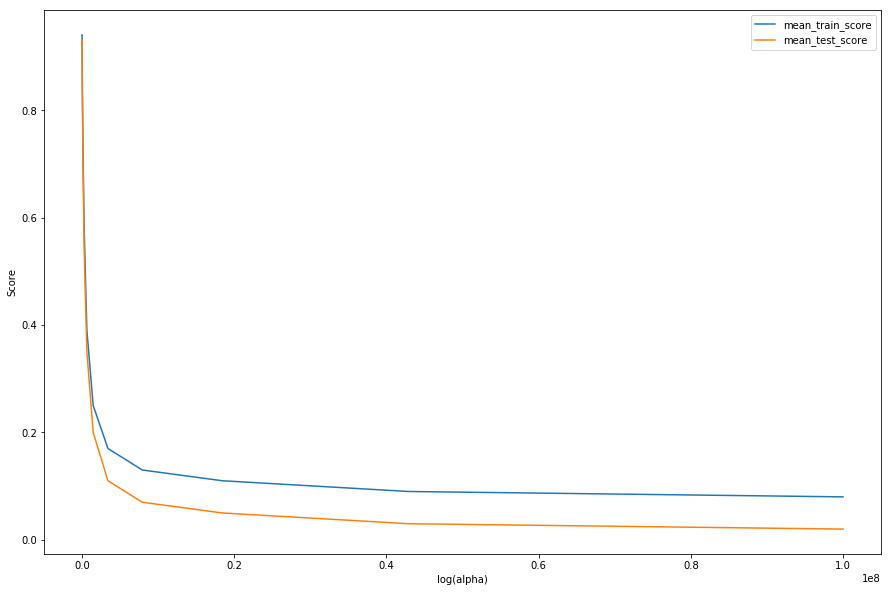

In [125]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = [round(score, 2) for score in grid_search_cv.cv_results_['mean_train_score']]
mean_test_scores = [round(score, 2) for score in grid_search_cv.cv_results_['mean_test_score']]
label_train, = ax.plot(param_grid['ridge__alpha'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['ridge__alpha'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [126]:
print(grid_search_cv.score(all_data, all_data_target))
print(grid_search_cv.score(data_2018, data_2018_target))

0.9439002244226872
0.8797984419177632


### Linear Model with numerical and categorical features

In [171]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [172]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [173]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [174]:
all_data = corr_column_remover.fit_transform(all_data)

#### Extracting necessary columns only

In [175]:
data_2018 = data_2018[all_data.columns]

In [176]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [177]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [178]:
mod_replacer = ModReplacer()
numerical_imputer = NumericalColumnImputer()
transmission_transformer = TransmissionTransformer()
categorical_transformer = CategoricalTransformer()

In [179]:
all_data = mod_replacer.fit_transform(all_data)
all_data  = transmission_transformer.fit_transform(all_data)
all_data = numerical_imputer.fit_transform(all_data)
all_data = categorical_transformer.fit_transform(all_data)

In [180]:
data_2018 = mod_replacer.transform(data_2018)
data_2018 = transmission_transformer.transform(data_2018)
data_2018 = numerical_imputer.transform(data_2018)
data_2018 = categorical_transformer.transform(data_2018)

In [181]:
param_grid = {'alpha': np.logspace(-3,3,50)}

In [182]:
grid_search_ridge = GridSearchCV(Ridge(), param_grid, cv = 5, n_jobs = -1, return_train_score = True)

In [183]:
grid_search_ridge.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-03, 1.32571e-03, 1.75751e-03, 2.32995e-03, 3.08884e-03,
       4.09492e-03, 5.42868e-03, 7.19686e-03, 9.54095e-03, 1.26486e-02,
       1.67683e-02, 2.22300e-02, 2.94705e-02, 3.90694e-02, 5.17947e-02,
       6.86649e-02, 9.10298e-02, 1.20679e-01, 1.59986e-01, 2.12... 1.84207e+02, 2.44205e+02,
       3.23746e+02, 4.29193e+02, 5.68987e+02, 7.54312e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

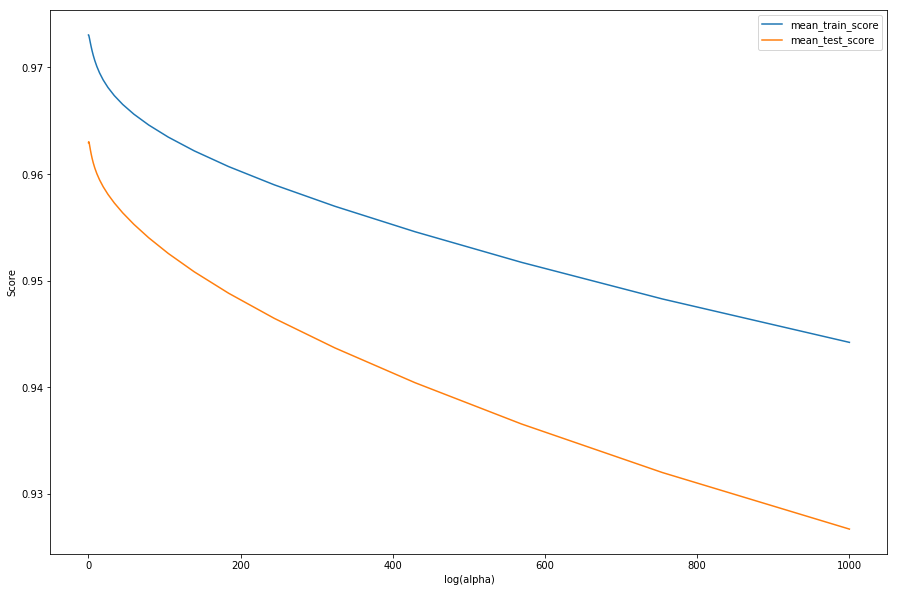

In [185]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = grid_search_ridge.cv_results_['mean_train_score']
mean_test_scores = grid_search_ridge.cv_results_['mean_test_score']
label_train, = ax.plot(param_grid['alpha'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['alpha'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [186]:
print(grid_search_ridge.score(all_data, all_data_target))
print(grid_search_ridge.score(data_2018, data_2018_target))

0.9726940134845239
0.873055829606813


### Task2: Linear regression with Polynomial transformation on Numerical Features

In [18]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [19]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [20]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [21]:
all_data = corr_column_remover.fit_transform(all_data)

#### Extracting necessary columns only

In [22]:
data_2018 = data_2018[all_data.columns]

In [23]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [24]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [25]:
mod_replacer = ModReplacer()
transmission_transformer = TransmissionTransformer()
numerical_imputer = NumericalColumnImputer()
my_transformer = MyTransformer(PolynomialFeatures())

In [26]:
all_data = mod_replacer.fit_transform(all_data)
all_data = transmission_transformer.fit_transform(all_data)
all_data = numerical_imputer.fit_transform(all_data)
all_data = my_transformer.fit_transform(all_data)

In [27]:
data_2018 = mod_replacer.transform(data_2018)
data_2018 = transmission_transformer.transform(data_2018)
data_2018 = numerical_imputer.transform(data_2018)
data_2018 = my_transformer.transform(data_2018)

In [28]:
param_grid = {'alpha': np.logspace(-3,2,10)}

In [29]:
grid_search_poly_ridge = GridSearchCV(Ridge(), param_grid, cv = 5, n_jobs = -1, return_train_score = True)

In [30]:
grid_search_poly_ridge.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

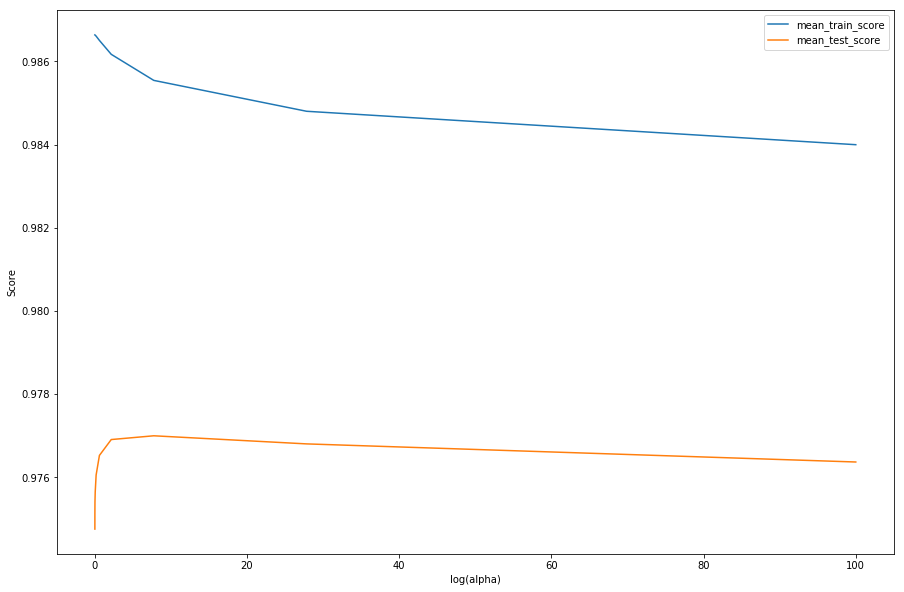

In [31]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = grid_search_poly_ridge.cv_results_['mean_train_score']
mean_test_scores = grid_search_poly_ridge.cv_results_['mean_test_score']
label_train, = ax.plot(param_grid['alpha'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['alpha'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [32]:
print(grid_search_poly_ridge.score(all_data, all_data_target))
print(grid_search_poly_ridge.score(data_2018, data_2018_target))

0.9852213062254541
0.9045773993343521


### Task3: Any Model

#### Random forest regressor

In [33]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [34]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [35]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [36]:
all_data = corr_column_remover.fit_transform(all_data)

In [37]:
data_2018 = data_2018[all_data.columns]

In [38]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [39]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [40]:
mod_replacer = ModReplacer()
numerical_imputer = NumericalColumnImputer()
transmission_transformer = TransmissionTransformer()
categorical_transformer = CategoricalTransformer()

In [41]:
all_data = mod_replacer.fit_transform(all_data)
all_data  = transmission_transformer.fit_transform(all_data)
all_data = numerical_imputer.fit_transform(all_data)
all_data = categorical_transformer.fit_transform(all_data)

In [42]:
data_2018 = mod_replacer.transform(data_2018)
data_2018 = transmission_transformer.transform(data_2018)
data_2018 = numerical_imputer.transform(data_2018)
data_2018 = categorical_transformer.transform(data_2018)

In [43]:
param_grid = {'n_estimators': np.arange(5,15)}

In [44]:
grid_search_rfr = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, n_jobs = -1, return_train_score = True)

In [45]:
grid_search_rfr.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

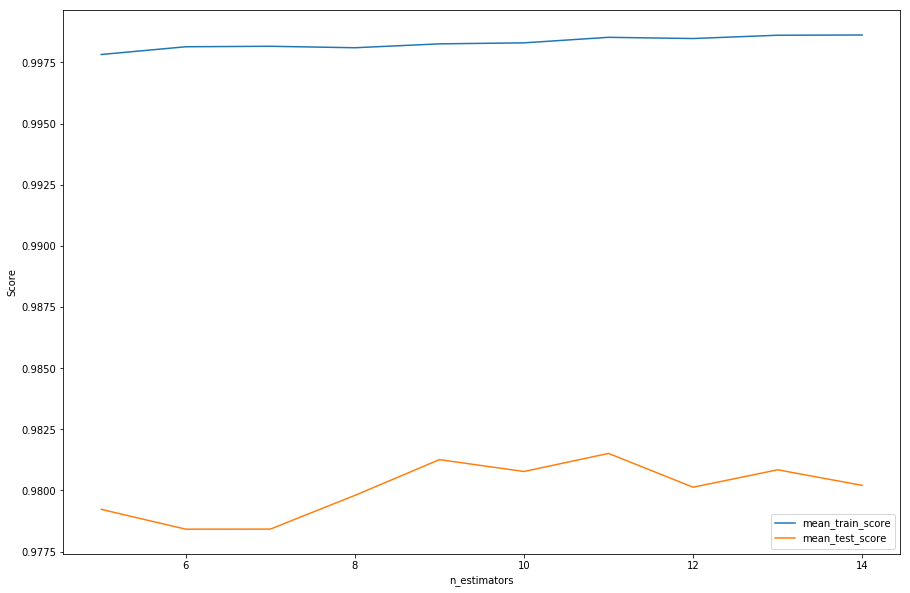

In [46]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = grid_search_rfr.cv_results_['mean_train_score']
mean_test_scores = grid_search_rfr.cv_results_['mean_test_score']
label_train, = ax.plot(param_grid['n_estimators'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['n_estimators'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [47]:
print(grid_search_rfr.score(all_data, all_data_target))
print(grid_search_rfr.score(data_2018, data_2018_target))

0.9985189460936613
0.903673413999812


#### Decision tree regressor

In [48]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [49]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [50]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [51]:
all_data = corr_column_remover.fit_transform(all_data)

In [52]:
data_2018 = data_2018[all_data.columns]

In [53]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [54]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [55]:
mod_replacer = ModReplacer()
numerical_imputer = NumericalColumnImputer()
transmission_transformer = TransmissionTransformer()
categorical_transformer = CategoricalTransformer()

In [56]:
all_data = mod_replacer.fit_transform(all_data)
all_data  = transmission_transformer.fit_transform(all_data)
all_data = numerical_imputer.fit_transform(all_data)
all_data = categorical_transformer.fit_transform(all_data)

In [57]:
data_2018 = mod_replacer.transform(data_2018)
data_2018 = transmission_transformer.transform(data_2018)
data_2018 = numerical_imputer.transform(data_2018)
data_2018 = categorical_transformer.transform(data_2018)

In [58]:
param_grid = {'max_depth': np.arange(2,8)}

In [59]:
grid_search_dtr = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5, n_jobs = -1, return_train_score = True)

In [60]:
grid_search_dtr.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

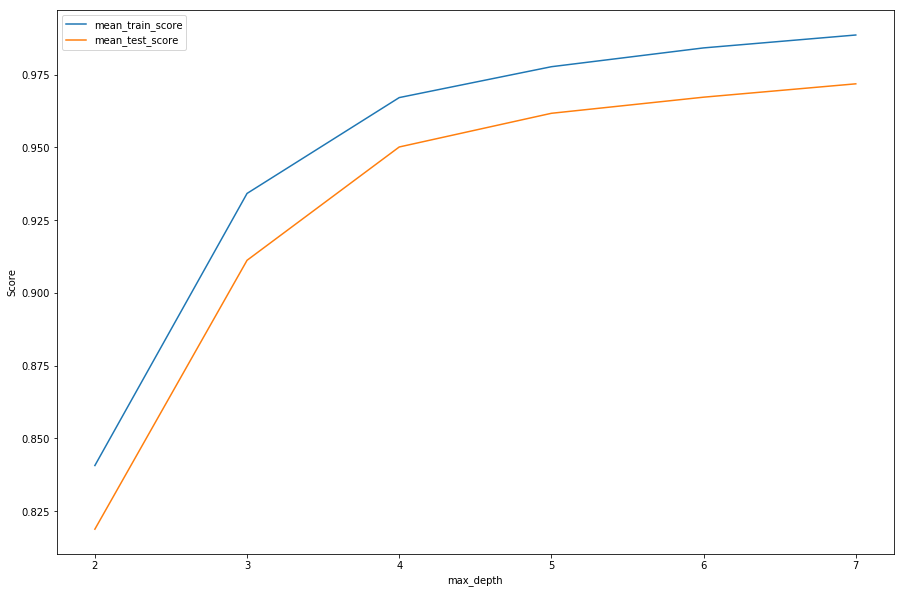

In [61]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = grid_search_dtr.cv_results_['mean_train_score']
mean_test_scores = grid_search_dtr.cv_results_['mean_test_score']
label_train, = ax.plot(param_grid['max_depth'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['max_depth'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [62]:
print(grid_search_dtr.score(all_data, all_data_target))
print(grid_search_dtr.score(data_2018, data_2018_target))

0.9877055681261295
0.8695395515969874


#### Dummy transformation to get column names

In [63]:
# dummy_transformation = make_pipeline(ModReplacer(), NumericalColumnImputer(), TransmissionTransformer(), CategoricalTransformer())
# dummy_data = dummy_transformation.fit_transform(all_data)
# list_of_columns = list(dummy_data.columns)

In [64]:
# plt.scatter(np.arange(1, dummy_data.shape[1] + 1), random_forest_regressor.feature_importances_)

In [235]:
# all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [236]:
# data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

In [237]:
# corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [238]:
# all_data = corr_column_remover.fit_transform(all_data)

In [239]:
# data_2018 = data_2018[all_data.columns]

In [240]:
# all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
# del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [241]:
# data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
# del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [242]:
# mod_replacer = ModReplacer()
# numerical_imputer = NumericalColumnImputer()
# transmission_transformer = TransmissionTransformer()
# categorical_transformer = CategoricalTransformer()

In [243]:
# all_data = mod_replacer.fit_transform(all_data)
# all_data  = transmission_transformer.fit_transform(all_data)
# all_data = numerical_imputer.fit_transform(all_data)
# all_data = categorical_transformer.fit_transform(all_data)

In [244]:
# data_2018 = mod_replacer.transform(data_2018)
# data_2018 = transmission_transformer.transform(data_2018)
# data_2018 = numerical_imputer.transform(data_2018)
# data_2018 = categorical_transformer.transform(data_2018)

In [245]:
# param_grid = {'C': np.logspace(-3,3,10)}

In [246]:
# grid_search_svr = GridSearchCV(SVR(), param_grid, cv = 5)

In [247]:
# grid_search_svr.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

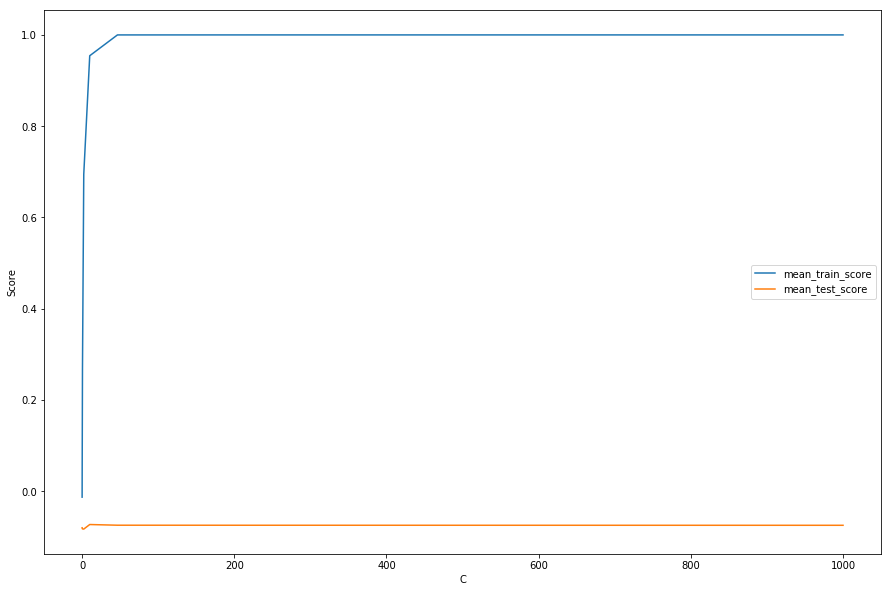

In [249]:
# fig = plt.figure(figsize=(15,10))
# ax = plt.gca()
# mean_train_scores = grid_search_svr.cv_results_['mean_train_score']
# mean_test_scores = grid_search_svr.cv_results_['mean_test_score']
# label_train, = ax.plot(param_grid['C'], mean_train_scores, label='mean_train_score')
# label_test, = ax.plot(param_grid['C'], mean_test_scores, label='mean_test_score')
# ax.set_xlabel('C')
# ax.set_ylabel('Score')
# ax.legend(handles=[label_train, label_test])

In [250]:
# print(grid_search_svr.score(all_data, all_data_target))
# print(grid_search_svr.score(data_2018, data_2018_target))

0.9538842490183865
0.11699180713108315


In [251]:
# print(grid_search_svr.best_params_)

{'C': 10.0}


#### Gradient Boosting Regressor

In [65]:
all_data = pd.read_excel('newdata/data_v1.xlsx', index = False)

In [66]:
data_2018 = pd.read_excel('data/2018FE.xlsx', index = False)

#### Columns that are highly/weakly correlated are removed in the beginning. Doesn't work consistently with cross validation

In [67]:
corr_column_remover = CorrColumnRemover(lower_bound_on_corr=0.1, higher_bound_on_corr=0.8)

In [68]:
all_data = corr_column_remover.fit_transform(all_data)

In [69]:
data_2018 = data_2018[all_data.columns]

In [70]:
all_data_target = all_data['Comb Unrd Adj FE - Conventional Fuel']
del all_data['Comb Unrd Adj FE - Conventional Fuel']

In [71]:
data_2018_target = data_2018['Comb Unrd Adj FE - Conventional Fuel']
del data_2018['Comb Unrd Adj FE - Conventional Fuel']

In [72]:
mod_replacer = ModReplacer()
numerical_imputer = NumericalColumnImputer()
transmission_transformer = TransmissionTransformer()
categorical_transformer = CategoricalTransformer()

In [73]:
all_data = mod_replacer.fit_transform(all_data)
all_data  = transmission_transformer.fit_transform(all_data)
all_data = numerical_imputer.fit_transform(all_data)
all_data = categorical_transformer.fit_transform(all_data)

In [74]:
data_2018 = mod_replacer.transform(data_2018)
data_2018 = transmission_transformer.transform(data_2018)
data_2018 = numerical_imputer.transform(data_2018)
data_2018 = categorical_transformer.transform(data_2018)

In [75]:
param_grid = {'max_depth': np.arange(2,6)}

In [78]:
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid, cv = 5, n_jobs = -1, return_train_score = True)

In [79]:
grid_search_gbr.fit(all_data, all_data_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

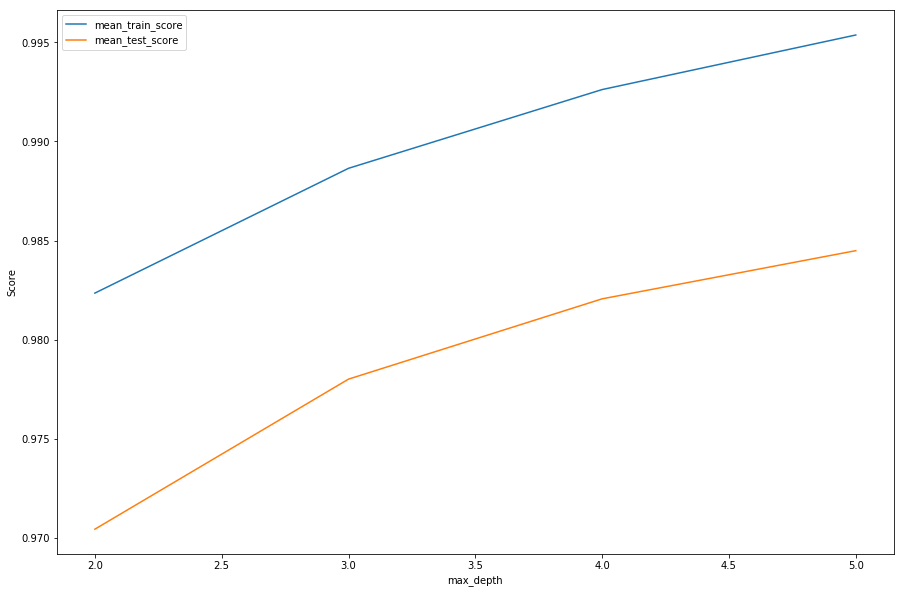

In [80]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
mean_train_scores = grid_search_gbr.cv_results_['mean_train_score']
mean_test_scores = grid_search_gbr.cv_results_['mean_test_score']
label_train, = ax.plot(param_grid['max_depth'], mean_train_scores, label='mean_train_score')
label_test, = ax.plot(param_grid['max_depth'], mean_test_scores, label='mean_test_score')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.legend(handles=[label_train, label_test])

In [81]:
print(grid_search_gbr.score(all_data, all_data_target))
print(grid_search_gbr.score(data_2018, data_2018_target))

0.9950078033124082
0.9147199315661131
